In [1]:
import random

import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

from sklearn.metrics import classification_report, roc_auc_score
from sklearn.metrics import roc_curve, auc


import uproot 
import awkward as ak

In [2]:
file = "/home/dejavu/Projects/qgcal/Sample_Inspect/dijet_sample_flatten.npy"
all_jets = np.load(file)

In [3]:
print(f"Before remove 0 weight jets: {all_jets.shape}")

Before remove 0 weight jets: (72778406, 8)


In [5]:
all_jets = all_jets[np.where(all_jets[:,-1] > 0)]

In [6]:
print(f"After remove weight <=0 jets: {all_jets.shape}")

After remove weight <=0 jets: (72705432, 8)


In [7]:
gluon_idx = np.where(all_jets[:,-2]==21)[0]
light_quark_idx = np.where((all_jets[:,-2]==1) | (all_jets[:,-2]==2)| (all_jets[:,-2]==3))[0]
gluon = all_jets[gluon_idx]
quark = all_jets[light_quark_idx]

In [8]:
features_name = ["jet_pt", "jet_eta", "jet_nTracks", "jet_trackWidth", "jet_trackC1", "jet_trackBDT", "jet_PartonTruthLabelID", "event_weight"]
features_name = np.array(features_name)

In [9]:
gluon.shape

(33474267, 8)

In [10]:
quark.shape

(36499377, 8)

In [11]:
nevents = 100000
X = np.concatenate((quark[:nevents], gluon[:nevents]), axis=0)
y = np.concatenate((np.zeros(nevents), 1.0 * np.ones(nevents)))

In [12]:
np.save("bdt_sample.npy", X, y)

In [13]:
from sklearn.model_selection import train_test_split

X_dev,X_eval, y_dev,y_eval = train_test_split(X, y, test_size=0.1, random_state=456)
X_train, X_test, y_train, y_test = train_test_split(X_dev, y_dev, test_size=0.1/0.9, random_state=789)

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import classification_report, roc_auc_score

dt = DecisionTreeClassifier(max_depth=5,
                            min_samples_leaf=0.001,
                            max_features="auto")
bdt = AdaBoostClassifier(dt,
                         algorithm='SAMME',
                         n_estimators=600,
                         learning_rate=0.5)

bdt.fit(X_train[:, :5], y_train, sample_weight=X_train[:,-1])


In [22]:
y_test_decisions = bdt.decision_function(X_test[:, :5])

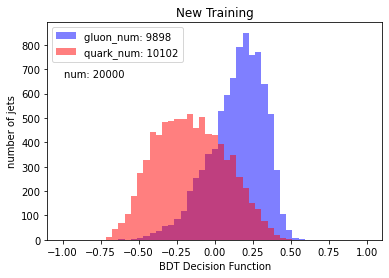

In [43]:
y_test_gluon_id = np.where(y_test==1)[0]
y_test_quark_id = np.where(y_test==0)[0]
bins_scores = np.linspace(-1, 1, 50)
plt.hist(y_test_decisions[y_test_gluon_id], weights=X_test[y_test_gluon_id][:, -1], bins= bins_scores, alpha=0.5, label='gluon'+f"_num: {len(y_test_gluon_id)}", color = 'blue') # add the weights! 
plt.hist(y_test_decisions[y_test_quark_id], weights=X_test[y_test_quark_id][:, -1], bins= bins_scores, alpha=0.5, label='quark'+f"_num: {len(y_test_quark_id)}", color = 'red')
plt.legend(loc='upper left')
plt.text(0.05, 0.75, f"num: {len(X_test)}", transform=plt.gca().transAxes)
plt.xlabel("BDT Decision Function")
plt.ylabel("number of jets")
plt.title("New Training")
plt.show()


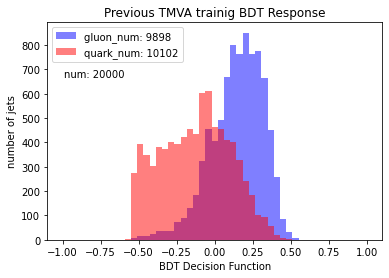

In [44]:
bins_scores_tmva = np.linspace(-1, 1, 50)
plt.hist(X_test[:,-3][y_test_gluon_id], bins_scores_tmva, weights=X_test[:,-1][y_test_gluon_id], alpha=0.5, label='gluon'+f"_num: {len(y_test_gluon_id)}", color = 'blue')
plt.hist(X_test[:,-3][y_test_quark_id], bins_scores_tmva, weights=X_test[:,-1][y_test_quark_id], alpha=0.5, label='quark'+f"_num: {len(y_test_quark_id)}", color = 'red')
plt.legend(loc='upper left')
plt.text(0.05, 0.75, f"num: {len(X_test)}", transform=plt.gca().transAxes)
plt.xlabel("BDT Decision Function")
plt.ylabel("number of jets")
plt.title("Previous TMVA trainig BDT Response")
plt.show()

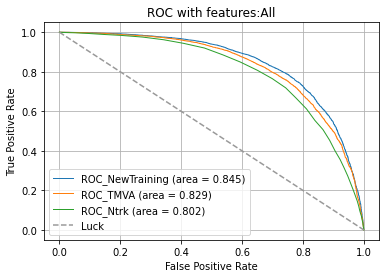

In [27]:
Draw_ROC_all(y_test, y_test_decisions, y_tmva=X_test[:,-3] , y_ntrk=X_test[:,2], X_weight=X_test[:, -1], features="All")

In [28]:
import pickle
filename = 'bdt_model.sav'
pickle.dump(bdt, open(filename, 'wb'))

In [16]:
def Draw_ROC_all(y, decisions, y_tmva, y_ntrk, X_weight, features):
    # Compute ROC curve and area under the curve
    fpr, tpr, thresholds = roc_curve(y, decisions, sample_weight = X_weight)
    fpr_tmva, tpr_tmva, thresholds_tmva = roc_curve(y, y_tmva, sample_weight = X_weight)
    fpr_ntrk, tpr_ntrk, thresholds_ntrk =  roc_curve(y, y_ntrk, sample_weight = X_weight)

    roc_auc = auc(fpr, tpr)
    roc_auc_tmva = auc(fpr_tmva, tpr_tmva)
    roc_auc_ntrk = auc(fpr_ntrk, tpr_ntrk)


    plt.plot(1-fpr, tpr, lw=1, label='ROC_NewTraining (area = %0.3f)'%(roc_auc))
    plt.plot(1-fpr_tmva, tpr_tmva, lw=1, label='ROC_TMVA (area = %0.3f)'%(roc_auc_tmva))
    plt.plot(1-fpr_ntrk, tpr_ntrk, lw=1, label='ROC_Ntrk (area = %0.3f)'%(roc_auc_ntrk))

    plt.plot([0, 1], [1, 0], '--', color=(0.6, 0.6, 0.6), label='Luck')
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC with features:{features}')
    plt.legend(loc="lower left")
    plt.grid()
    plt.show()


def train_bdt_features(X_train, y_train, X_train_weight, X_test, y_test, X_test_weight, features, y_tmva, y_ntrk, algo="SAMME", lr=0.5, truth_bkg_label = -1):
    print("=====================================================================================================")
    print(f"Traning with features:{features}")
    from sklearn.tree import DecisionTreeClassifier
    from sklearn.ensemble import AdaBoostClassifier
    from sklearn.metrics import classification_report, roc_auc_score

    dt = DecisionTreeClassifier(max_depth=5,
                                min_samples_leaf=0.002,
                                max_features="auto")
    bdt = AdaBoostClassifier(dt,
                            algorithm=algo,
                            n_estimators=600,
                            learning_rate=lr)

    bdt.fit(X_train, y_train, sample_weight=X_train_weight)
    y_test_decisions = bdt.decision_function(X_test)

    
    y_test_gluon_id = np.where(y_test==1)[0]
    y_test_quark_id = np.where(y_test==truth_bkg_label)[0]
    bins_scores = np.linspace(-1, 1, 50)
    plt.hist(y_test_decisions[y_test_gluon_id], weights=X_test_weight[y_test_gluon_id], bin= bins_scores, alpha=0.5, label='gluon', color = 'blue') # add the weights! 
    plt.hist(y_test_decisions[y_test_quark_id], weights=X_test_weight[y_test_quark_id], bin= bins_scores, alpha=0.5, label='quark', color = 'red')
    plt.legend(loc='upper right')
    plt.xlabel("BDT Decision Function")
    plt.ylabel("number of jets")
    plt.title(f"training features: {features}")
    plt.show()

    bins_scores_tmva = np.linspace(-1, 1, 50)
    plt.hist(y_tmva[y_test_gluon_id], bins_scores_tmva, alpha=0.5, label='gluon', color = 'blue')
    plt.hist(y_tmva[y_test_quark_id], bins_scores_tmva, alpha=0.5, label='quark', color = 'red')
    plt.legend(loc='upper right')
    plt.xlabel("BDT Decision Function")
    plt.ylabel("number of jets")
    plt.title("Previous TMVA trainig BDT Response")
    plt.show()

    Draw_ROC_all(y=y_test,y_tmva = y_tmva, y_ntrk=y_ntrk, decisions = y_test_decisions, X_weight=X_test_weight, features=features)

Traning with features:['jet_pt' 'jet_eta' 'jet_nTracks' 'jet_trackWidth' 'jet_trackC1']


ValueError: weights should have the same shape as x

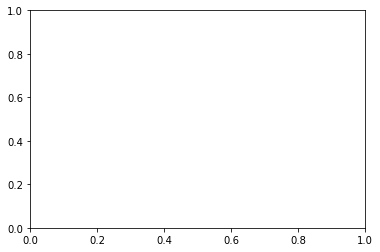

In [18]:
train_bdt_features(X_train[:,:5], y_train, X_train_weight=X_train[:,-1], 
                    X_test=X_test[:,:5], y_test=y_test, X_test_weight= X_test[:,-1],
                    features = features_name[0:5], y_tmva=X_test[:,-3] , y_ntrk=X_test[:,2],
                    algo="SAMME", lr=0.5, truth_bkg_label = 0 )

In [20]:
X_test[:,-1].shape

(20000,)